This is the implementation of DCGAN without any improvement
- Number of epochs: 50
- lr: 0.0002

# Import

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 
#https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=ec68d389aea9cc5b7cb0d1e4605882bdb00422d3a1f71f5535e56baaa63b58d0
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 111.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
import argparse
import os
import time
import pickle

In [ ]:
pip install torchnet

     |████████████████████████████████| 686kB 4.2MB/s 
     |████████████████████████████████| 204kB 9.8MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-cp36-none-any.whl size=29747 sha256=7528054535304bff0e4a5eaeb5b1e215f5689fd407c0d1351d9164317e79739a
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655251 sha256=5dc2da9167b32604589001eeaaaa65c455e597ed0645234846160f146ff43a1b
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5711 sha256=fcfca551e2f8e02b64ab2235e97fe6396a7b93d5e03993a3c9a238c41a297a2d
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchnet.meter import AverageValueMeter

# Define Arguments

In [ ]:
parser = {
    'data_path': '../data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/',
    'epochs': 50,
    #CHANGEMENT DU BATCH
    #'batch_size': 64,
    'batch_size': 94,
    'lr': 0.0002,

    'image_size': 136,
    'scale_size': 64,
    'z_dim': 100,

    'G_features': 64,
    'D_features': 64,
    
    'image_channels': 3,
    'beta1': 0.5,
    'cuda': True,
    'seed': 7,
    'workers': 2,
    'results': './resultsDCGAN1_0801/'
    
}
args = argparse.Namespace(**parser)
args.image_results = args.results + 'images/'
args.loss_results = args.results + 'loss/'
args.cuda = args.cuda and torch.cuda.is_available()

if not os.path.isdir(args.data_path):
    os.makedirs(args.data_path)
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.image_results):
    os.makedirs(args.image_results)
if not os.path.isdir(args.loss_results):
    os.makedirs(args.loss_results)
    
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Prepare Data

**Note: all iamges have size 136x102**

In [ ]:
#activate my images folder in google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive'

'20200713_Catherine_DXC Intégrer une IA dans une application existante - all.docx'
'Colab Notebooks'
 DCGAN_2.ipynb
 DCGAN_3.ipynb
 DCGAN_4.ipynb
 DCGAN_4_modified_0605.ipynb


In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks/Sneakers_and_Athletic_Shoes_split/1'

10000.jpg  11655.jpg  1734.jpg	3388.jpg  5040.jpg  6695.jpg  8348.jpg
10001.jpg  11656.jpg  1735.jpg	3389.jpg  5041.jpg  6696.jpg  8349.jpg
10002.jpg  11657.jpg  1736.jpg	338.jpg   5042.jpg  6697.jpg  834.jpg
10003.jpg  11658.jpg  1737.jpg	3390.jpg  5043.jpg  6698.jpg  8350.jpg
10004.jpg  11659.jpg  1738.jpg	3391.jpg  5044.jpg  6699.jpg  8351.jpg
10005.jpg  1165.jpg   1739.jpg	3392.jpg  5045.jpg  669.jpg   8352.jpg
10006.jpg  11660.jpg  173.jpg	3393.jpg  5046.jpg  66.jpg    8353.jpg
10007.jpg  11661.jpg  1740.jpg	3394.jpg  5047.jpg  6700.jpg  8354.jpg
10008.jpg  11662.jpg  1741.jpg	3395.jpg  5048.jpg  6701.jpg  8355.jpg
10009.jpg  11663.jpg  1742.jpg	3396.jpg  5049.jpg  6702.jpg  8356.jpg
1000.jpg   11664.jpg  1743.jpg	3397.jpg  504.jpg   6703.jpg  8357.jpg
10010.jpg  11665.jpg  1744.jpg	3398.jpg  5050.jpg  6704.jpg  8358.jpg
10011.jpg  11666.jpg  1745.jpg	3399.jpg  5051.jpg  6705.jpg  8359.jpg
10012.jpg  11667.jpg  1746.jpg	339.jpg   5052.jpg  6706.jpg  835.jpg
10013.jpg  11668.jpg  1

In [ ]:
!unzip /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1.zip -d /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/55.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/550.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5500.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5501.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5502.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5503.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5504.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5505.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5506.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5507.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5508.jpg  
  inflating: /data/ut-zap50k/Shoes/Sneakers_and_athletic_shoes/1/5509.jpg  
  inflating: 

In [ ]:
from folder import ImageFolder

ModuleNotFoundError: ignored

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
from torchvision.transforms import ToPILImage
to_image = ToPILImage()

In [ ]:
def get_loader(image_root, batch_size, scale_size, num_workers=2, shuffle=True):
    #image_root = os.path.join(root, 'splits', split)
    dataset = ImageFolder(root=image_root, transform=transforms.Compose([
            transforms.Pad(34, fill=(255, 255, 255)), # padding images with (255,255,255) --> pad 255 in 3 channels
            transforms.CenterCrop((136,136)),
            transforms.Scale(scale_size),
            transforms.ToTensor(),
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, num_workers=int(num_workers))
    #data_loader.shape = [int(num) for num in dataset[0][0].size()]
    #print(data_loader.shape)
    return data_loader

In [ ]:
dataloader = get_loader(args.data_path, args.batch_size, args.scale_size)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:257: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


## Test One Image

In [ ]:
test_image = 0
for data, _ in dataloader:
    print(data[0])
    test_image = data[0]
    break

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


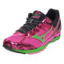

In [ ]:
to_image(test_image)

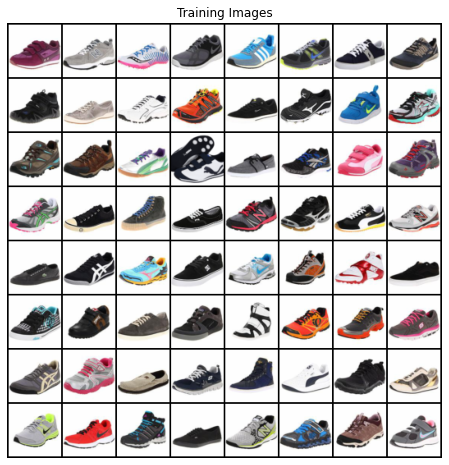

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Define Model

## Define G

In [ ]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(args.z_dim, args.G_features * 8,
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(args.G_features * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(args.G_features * 8, args.G_features * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(args.G_features * 4, args.G_features * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(args.G_features * 2, args.G_features,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(args.G_features),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(args.G_features, args.image_channels,
                               4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
        self._initialize_weights()

        
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, x):
        return self.main(x)

## Define D

In [ ]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            #nn.Conv2d modules expect a 4-dimensional tensor with the shape [batch_size, channels, height, width].
            nn.Conv2d(args.image_channels, args.D_features,                   
                      4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(args.D_features, args.D_features * 2,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(args.D_features * 2, args.D_features * 4,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(args.D_features * 4, args.D_features * 8,
                      4, 2, 1, bias=False),
            nn.BatchNorm2d(args.D_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(args.D_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

## Save losses

In [ ]:
class Results():
    def __init__(self, results_path):
        self.D_losses = []
        self.G_losses = []
        self.D_reals = []
        self.D_fakes = []
        self.G_reals = []
        self.results_path = results_path
    
    def save_losses(self, D_loss, G_loss, D_real, D_fake, G_real):
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.D_reals.append(D_real)
        self.D_fakes.append(D_fake)
        self.G_reals.append(G_real)
        
    def save_to_disk(self):
        f = open(self.results_path + "D_losses.pkl", "wb")
        pickle.dump(self.D_losses, f)
        f= open(self.results_path + "G_losses.pkl", "wb")
        pickle.dump(self.G_losses, f)
        f = open(self.results_path + "D_reals.pkl", "wb")
        pickle.dump(self.D_reals, f)
        f = open(self.results_path + "D_fakes.pkl", "wb")
        pickle.dump(self.D_fakes, f)
        f = open(self.results_path + "G_reals.pkl", "wb")
        pickle.dump(self.G_reals, f)
        

## Define Train and Generate

In [ ]:
def train(args, data_loader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses):
    D_losses = AverageValueMeter()
    G_losses = AverageValueMeter()
    D_reals = AverageValueMeter()
    D_fakes = AverageValueMeter()
    G_reals = AverageValueMeter()
    
    start = time.time()
    # call Variable after .cuda()
    for i, (real, _) in enumerate(data_loader):
        batch_size = real.size(0)
        real_label = torch.ones(batch_size)
        fake_label = torch.zeros(batch_size)
        z = torch.randn(batch_size, args.z_dim, 1, 1)

        if args.cuda:
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()
            real = real.cuda()
            z = z.cuda()
        real_label = Variable(real_label)
        fake_label = Variable(fake_label)
        real = Variable(real)
        z = Variable(z)
        
        #----------TRAIN D---------------
        # train with real
        real_output = netD(real)
        D_real_loss = criterion(real_output, real_label)
        D_real = real_output.data.mean()
        
        # train with fake
        fake = netG(z)
        fake_output = netD(fake.detach())
        D_fake_loss = criterion(fake_output, fake_label)
        D_fake = fake_output.data.mean()
        
        # loss D
        D_loss = D_real_loss + D_fake_loss
        netD.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        #----------TRAIN G---------------
        output = netD(fake)
        G_loss = criterion(output, real_label)
        G_real = output.data.mean()
        netG.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # update loss
        #tensor.item() & .data.cpu().item()
        D_losses.add(D_loss.data.cpu().item() * batch_size, batch_size)
        G_losses.add(G_loss.data.cpu().item() * batch_size, batch_size)
        D_reals.add(D_real.data.cpu().item() * batch_size, batch_size)
        D_fakes.add(D_fake.data.cpu().item() * batch_size, batch_size)
        G_reals.add(G_real.data.cpu().item() * batch_size, batch_size)
        
    print("=> EPOCH {} | Time: {}s | D_loss: {:.4f} | G_loss: {:.4f}"
          " | D_real: {:.4f} | D_fake: {:.4f} | G_real: {:.4f}"
          .format(epoch, round(time.time()-start), D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0]))
    result_losses.save_losses(D_losses.value()[0],
                  G_losses.value()[0], D_reals.value()[0],
                  D_fakes.value()[0], G_reals.value()[0])

In [ ]:
aten = torch.tensor(2)   
aten[0]

In [ ]:
aten.item()

In [ ]:
import torchvision.utils as vutils
#image liste pour l'animation
img_list = []

def generate(args, netG, epoch):
    z = torch.randn(args.batch_size, args.z_dim, 1, 1)
    if args.cuda:
        z = z.cuda()
    fake = netG(Variable(z, volatile=True))
    
    save_image(fake.data.cpu(), os.path.join(args.results,
        "fake_sample_epoch_{:02d}.png".format(epoch)), normalize=True)
    
    #image liste pour l'animation
    #add .data.cpu()
    img_list.append(vutils.make_grid(fake.data.cpu(), padding=2, normalize=True))

## Create Model, Define Loss and Optimizer

In [ ]:
#apelle l'initialisation des poids
netG = _netG()
#apelle l'initialisation des poids 
netD = _netD()
criterion = nn.BCELoss()
if args.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [ ]:
D_optimizer = optim.Adam(netD.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)
G_optimizer = optim.Adam(netG.parameters(), lr=args.lr,
                         betas=(args.beta1, 0.999), weight_decay=1e-4)

## Run Train

In [ ]:
#test pour 5 epochs
result_losses = Results(args.loss_results)
for epoch in range(0, 5):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses)
    generate(args, netG, epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


=> EPOCH 0 | Time: 41s | D_loss: 0.0509 | G_loss: 5.9144 | D_real: 0.9773 | D_fake: 0.0227 | G_real: 0.0115


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


=> EPOCH 1 | Time: 41s | D_loss: 0.3614 | G_loss: 5.4312 | D_real: 0.8981 | D_fake: 0.1012 | G_real: 0.0598
=> EPOCH 2 | Time: 41s | D_loss: 0.0820 | G_loss: 5.6033 | D_real: 0.9655 | D_fake: 0.0345 | G_real: 0.0175
=> EPOCH 3 | Time: 41s | D_loss: 0.0540 | G_loss: 5.8385 | D_real: 0.9766 | D_fake: 0.0234 | G_real: 0.0135
=> EPOCH 4 | Time: 41s | D_loss: 0.0776 | G_loss: 6.0102 | D_real: 0.9706 | D_fake: 0.0294 | G_real: 0.0173


In [ ]:
#pour 50 epochsc
result_losses = Results(args.loss_results)
for epoch in range(0, args.epochs):
    train(args, dataloader, netG, netD, G_optimizer, D_optimizer,
          criterion, epoch, result_losses)
    generate(args, netG, epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([94])) that is different to the input size (torch.Size([94, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([75])) that is different to the input size (torch.Size([75, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


=> EPOCH 0 | Time: 11s | D_loss: 0.3296 | G_loss: 27.5691 | D_real: 0.9773 | D_fake: 0.0368 | G_real: 0.0002
=> EPOCH 1 | Time: 11s | D_loss: 1.0711 | G_loss: 4.8525 | D_real: 0.7304 | D_fake: 0.2709 | G_real: 0.0790
=> EPOCH 2 | Time: 11s | D_loss: 0.7225 | G_loss: 3.8925 | D_real: 0.7726 | D_fake: 0.2201 | G_real: 0.0815
=> EPOCH 3 | Time: 12s | D_loss: 0.8620 | G_loss: 3.3760 | D_real: 0.7396 | D_fake: 0.2611 | G_real: 0.1102
=> EPOCH 4 | Time: 12s | D_loss: 0.7648 | G_loss: 3.3130 | D_real: 0.7542 | D_fake: 0.2421 | G_real: 0.1066
=> EPOCH 5 | Time: 12s | D_loss: 0.8482 | G_loss: 2.9790 | D_real: 0.7285 | D_fake: 0.2678 | G_real: 0.1425
=> EPOCH 6 | Time: 11s | D_loss: 0.8276 | G_loss: 2.7996 | D_real: 0.7275 | D_fake: 0.2701 | G_real: 0.1373
=> EPOCH 7 | Time: 11s | D_loss: 0.8748 | G_loss: 2.7520 | D_real: 0.7147 | D_fake: 0.2854 | G_real: 0.1441
=> EPOCH 8 | Time: 11s | D_loss: 0.9008 | G_loss: 2.6901 | D_real: 0.7081 | D_fake: 0.2895 | G_real: 0.1541
=> EPOCH 9 | Time: 11s | D_

## Save loss

In [ ]:
result_losses.save_to_disk()

## Get one REAL Image

In [ ]:
sample, _ = iter(dataloader).next()
save_image(sample, os.path.join(args.results, "real_sample.png"))

## Results

D and G’s losses changed during training

In [ ]:
loss_path = '/content/resultsDCGAN1_0801/loss/'
with open(loss_path+ 'D_losses.pkl', "rb") as f:
    D_losses = pickle.load(f)
    
with open(loss_path+ 'G_losses.pkl', "rb") as f:
    G_losses = pickle.load(f)

with open(loss_path+ 'D_reals.pkl', "rb") as f:
    D_reals = pickle.load(f)

with open(loss_path+ 'D_fakes.pkl', "rb") as f:
    D_fakes = pickle.load(f)

with open(loss_path+ 'G_reals.pkl', "rb") as f:
    G_reals = pickle.load(f)

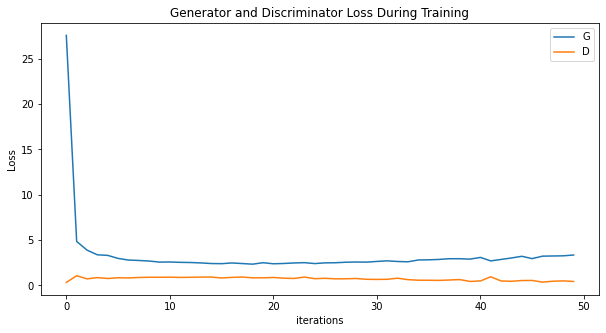

<Figure size 432x288 with 0 Axes>

In [ ]:
#Loss versus training iteration

import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(loss_path + 'Loss_DCGAN1.png')
plt.show()





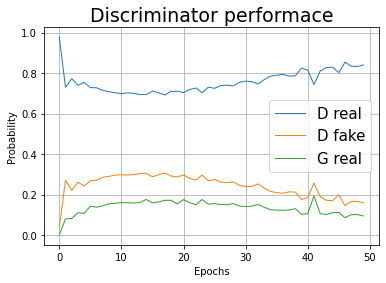

In [ ]:
plt.plot(D_reals, linewidth=1, label="D real")
plt.plot(D_fakes, linewidth=1, label="D fake")
plt.plot(G_reals, linewidth=1, label="G real")
plt.grid()
plt.legend(fontsize=15)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Probability", fontsize=10)
plt.title('Discriminator performace', fontsize=19)
plt.savefig(loss_path + 'D_DCGAN1.png')
plt.show()


##Visualization of G’s progression




Generator’s output on the fixed_noise batch after every epoch of training. Now, we can visualize the training progression of G with an animation. Press the play button to start the animation.
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
len(img_list)

5

In [ ]:
#%%capture
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

##Real Images vs. Fake Images

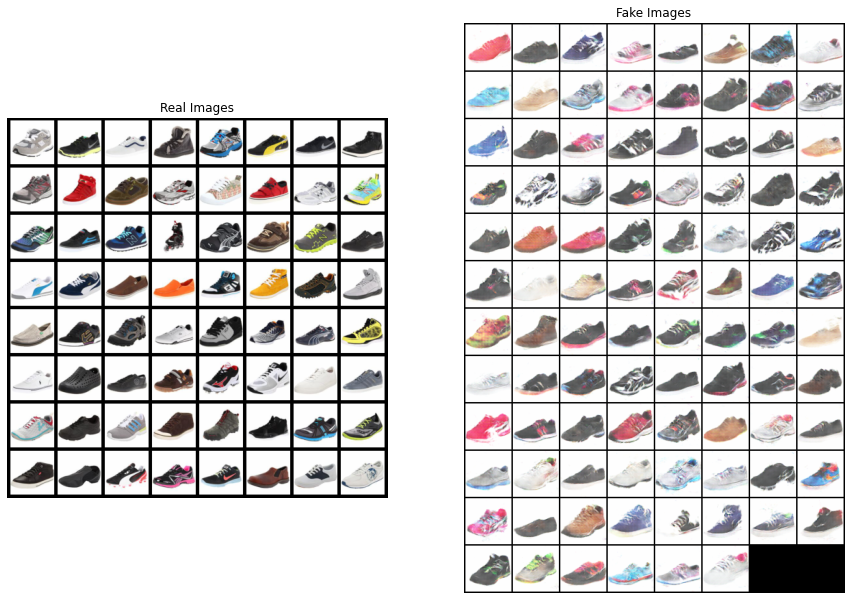

In [ ]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

##Transfer learned weight in the model 
https://discuss.pytorch.org/t/how-to-transfer-learned-weight-in-the-same-model-without-last-layer/32824/6

In [ ]:
#apelle l'initialisation des poids
netG = _netG()
#apelle l'initialisation des poids 
netD = _netD()
z = torch.randn(args.batch_size, args.z_dim, 1, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [ ]:
# Init model and train
modelG = _netG()  
output = modelG(z)    
print(output.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


torch.Size([94, 3, 64, 64])


In [ ]:
# Init model and train
modelD = _netD()  
z = torch.randn(args.batch_size, args.z_dim, 1, 1)
output = modelD(z)    
print(output.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


RuntimeError: ignored

In [ ]:
# Save "trained" state_dict
torch.save(modelG.state_dict(), '/content/resultsDCGAN1_0801/weights/modelG.pth')
torch.save(modelD.state_dict(), '/content/resultsDCGAN1_0801/weights/modelD.pth')

In [ ]:
# Reload model G and load state_dict
#ici les poids sont transférés au model _netG()   
modelG.load_state_dict(torch.load('/content/resultsDCGAN1_0801/weights/modelG.pth'))
modelD.load_state_dict(torch.load('/content/resultsDCGAN1_0801/weights/modelD.pth'))

<All keys matched successfully>

In [ ]:
!zip -r "/content/resultsDCGAN1_0801.zip" "/content/resultsDCGAN1_0801"

  adding: content/resultsDCGAN1_0801/ (stored 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_46.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_20.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_02.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_28.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_45.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_21.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_24.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_39.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_30.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_49.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_40.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/fake_sample_epoch_23.png (deflated 0%)
  adding: content/resultsDCGAN1_0801/f

In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks'

COLOR	      resultsDCGAN1_0801.zip		 TYPE
INPUT_FOLDER  SHAPE				 vgg16_weights.h5
MATIERE       Sneakers_and_Athletic_Shoes_split
PATTERN       TEST
